# Gaussian Process Regression - Theory

We discuss how to perform Gaussian process regression without and with measurement noise, tune the hyperparameters of the covariance function, and perform automatic relevance determination.
My exposition closely follows the Chapter 3 and Section 5.4 of {cite:p}`10.7551/mitpress/3206.001.0001`.

## Motivation: A fully Bayesian paradigm for curve fitting

Remember why we are doing this:

+ Let's say that you have to learn some function $f(\cdot)$ from some space $\mathcal{X}$ to $\mathbb{R}$ (this could either be a supervised learning problem (regression or classification) or even an unsupervised learning problem.

+ You sit down and you think about $f(\cdot)$. What do you know about it? How large do you expect it to be? How small do you expect it to be? Is it continuous? Is it differentiable? Is it periodic? How fast does it change as you change its inputs?

+ You create a probability measure on the space of functions in which $f(\cdot)$ lives, which is compatible with everything you know. Abusing mathematical notation a lot, let's write this probability measure as $p(f(\cdot))$. Now you can sample from it. Any sample you take is compatible with your prior beliefs. You cannot tell which one is better than any other. They could be the true $f(\cdot)$.

+ Then, you get some data, say $\mathcal{D}$. You model the likelihood of the data, $p(\mathcal{D}|f(\cdot))$, i.e., you model how the data may have been generated if you knew $f(\cdot)$.

+ Finally, you use Bayes' rule to come up with your posterior probability measure over the space of functions:

$$
p(f(\cdot)|\mathcal{D}) \propto p(\mathcal{D}|f(\cdot)) p(f(\cdot)),
$$

which is simultaneously compatible with your prior beliefs and the data.

In the previous lecture, we mathematically formalized the prior $p(f(\cdot))$.
Today, we will mathematically formalize the posterior $p(f(\cdot)|\mathcal{D})$.

## Reminder: The prior $p(f(\cdot))$

In the previous lecture, we defined $p(f(\cdot))$ through the concept of a Gaussian process (GP), a generalization of a multivariate Gaussian distribution to
*infinite* dimensions.
We argued that it defines a probability measure on a function space.
We wrote:

$$
f(\cdot) \sim \text{GP}\left(m(\cdot), k(\cdot, \cdot) \right),
$$

where 
$m:\mathbb{R}^d \rightarrow \mathbb{R}$ is the *mean function* and 
$k:\mathbb{R}^d \times \mathbb{R}^d \rightarrow \mathbb{R}$ is the *covariance function*.

We also discuss in detail the meaning of these equations.
Namely that for any points $\mathbf{x}_{1:n}=(\mathbf{x}_1,\dots,\mathbf{x}_n)$, the joint probability density of the function values:

$$
\mathbf{f}_{1:n} =
\left(
f(\mathbf{x}_1),
\dots,
f(\mathbf{x}_n)
\right).
$$

is the multivariate Gaussian:

$$
\mathbf{f}_{1:n} | \mathbf{x}_{1:n} \sim \mathcal{N}\left(\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) \right),
$$

with mean vector:

$$
\mathbf{m}(\mathbf{x}_{1:n}) =
\left(
m(\mathbf{x}_1),
\dots,
m(\mathbf{x}_n)
\right),
$$

and covariance matrix:

$$
\mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) = \left(
\begin{array}{ccc}
k(\mathbf{x}_1,\mathbf{x}_1) & \dots & k(\mathbf{x}_1, \mathbf{x}_n)\\
\vdots & \ddots & \vdots\\
k(\mathbf{x}_n, \mathbf{x}_1) & \dots & k(\mathbf{x}_n, \mathbf{x}_n)
\end{array}
\right).
$$

Please note that all the above expressions are conditional on the hyperparameters of the covariance function, e.g., lengthscales and signal variance for the squared exponential.
However, for now, we do not explicitly show this dependence.

## Gaussian process regression

Assume that the data we observe is:

$$
\mathcal{D} = (\mathbf{x}_{1:n}, y_{1:n}),
$$

where $y_i$ is not exactly $f(\mathbf{x}_i)$, but it may have some noise.
For the sake of simplicity, let's assume that the noise is Gaussian with variance $\sigma$ (you can relax this, but things will no longer be analytically available).
Assume that $\sigma$ is known (for now).
So, we have:

$$
y_i|f(\mathbf{x}_i) \sim \mathcal{N}(f(\mathbf{x}_i), \sigma^2),
$$

for a single observation.
For all the observations together, we can write:

$$
y_{1:n}| \mathbf{f}_{1:n} \sim \mathcal{N}(\mathbf{f}_{1:n}, \sigma^2\mathbf{I}_n),
$$

where $\mathbf{I}_n$ is the $n\times n$ unit matrix.

Let's draw a graphical model representation of what we have here.
Remember that $\sigma$ and the hyperparameters of the covariance function, let's call them $\theta$, are (for the time being) fixed.

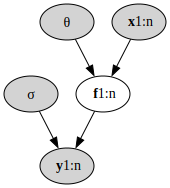

In [4]:
import numpy as npimport scipy.stats as stfrom graphviz import Digraphg = Digraph('gp')g.node('sigma', label='<&sigma;>', style='filled')g.node('theta', label='<&theta;>', style='filled')g.node('x1n', label='<<b>x</b><sub>1:n</sub>>', style='filled')g.node('f', label='<<b>f</b><sub>1:n</sub>>')g.node('y1n', label='<<b>y</b><sub>1:n</sub>>', style='filled')g.edge('theta', 'f')g.edge('x1n', 'f')g.edge('f', 'y1n')g.edge('sigma', 'y1n')g.render('gp_reg1', format='png')g

So far, so good, but how do we make predictions?
How do we get $p(f(\cdot)|\mathcal{D})$.
There are some nuances here.
We are looking for a posterior measure over a function space.
This is a strange beast.
We can only describe it through the joint probability density of the function values at any arbitrary collection of **test** points.
So, let's take $n^*$ such test points:

$$
\mathbf{x}^*_{1:n^*} = \left(\mathbf{x}^*_1,\dots,\mathbf{x}^*_{n^*}\right).
$$

Imagine that these cover the input space as densely as we wish.
Consider the vector of function values at these test points:

$$
\mathbf{f}^*_{1:n^*} = \left(f(\mathbf{x}_1^*),\dots,f(\mathbf{x}^*_{n^*})\right).
$$

We will derive the posterior over these points, i.e., we will derive $p(\mathbf{f}^*|\mathcal{D})$.
And we will be happy with that.

From the definition of the GP, we can now write the joint probability density of $\mathbf{f}$ and $\mathbf{f}^*$.
It is just a multivariate Gaussian.
We have:

$$
p(\mathbf{f}_{1:n}, \mathbf{f}^*_{1:n^*} | \mathbf{x}_{1:n}, \mathbf{x}^*_{1:n^*}) = \mathcal{N}\left(
\left(
\begin{array}{c}
\mathbf{f}_{1:n}\\
\mathbf{f}^*_{1:n^*}
\end{array}
\right)\middle |
\left(
\begin{array}{c}
\mathbf{m}(\mathbf{x}_{1:n})\\
\mathbf{m}(\mathbf{x}^*_{1:n^*})
\end{array}
\right),
\left(
\begin{array}{cc}
\mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}_{1:n}) & \mathbf{K}(\mathbf{x}_{1:n}, \mathbf{x}^*_{1:n^*})\\
\mathbf{K}(\mathbf{x}^*_{1:n^*}, \mathbf{x}_{1:n}) & \mathbf{K}(\mathbf{x}^*_{1:n^*}, \mathbf{x}_{1:n^*})
\end{array}
\right)
\right),
$$

where the block matrix is just the covariance matrix of all inputs $\mathbf{x}_{1:n}$ (observed) and $\mathbf{x}^*_{1:n^*}$ (test).
Let's visualize the situation again.

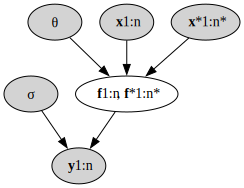

In [5]:
g2 = Digraph('gp2')
g2.node('sigma', label='<&sigma;>', style='filled')
g2.node('theta', label='<&theta;>', style='filled')
g2.node('x1n', label='<<b>x</b><sub>1:n</sub>>', style='filled')
g2.node('f', label='<<b>f</b><sub>1:n</sub>, <b>f</b>*<sub>1:n*</sub>>')
g2.node('y1n', label='<<b>y</b><sub>1:n</sub>>', style='filled')
g2.node('xs1ns', label='<<b>x</b>*<sub>1:n*</sub>>', style='filled')
g2.edge('theta', 'f')
g2.edge('x1n', 'f')
g2.edge('f', 'y1n')
g2.edge('xs1ns', 'f')
g2.edge('sigma', 'y1n')
g2.render('gp_reg2', format='png')
g2

Okay, now we have only finite-dimensional probability densities.
This is great. We know what to do next.
We will use the basic probability rules:

$$
\begin{array}{ccc}
p(\mathbf{f}^*_{1:n^*} | \mathbf{x}^*_{1:n^*}, \mathcal{D}) &=& p(\mathbf{f}^*_{1:n^*} | \mathbf{x}^*_{1:^*}, \mathbf{x}_{1:n}, \mathbf{y}_{1:n})\\
&=& \int p(\mathbf{f}_{1:n}, \mathbf{f}^*_{1:n^*} | \mathbf{x}^*_{1:^*}, \mathbf{x}_{1:n}, \mathbf{y}_{1:n})d\mathbf{f}_{1:n}\;\text{(sum rule)}\\
&\propto& \int p(\mathbf{y}_{1:n}| \mathbf{f}_{1:n}) p(\mathbf{f}_{1:n}, \mathbf{f}^*_{1:n^*}|\mathbf{x}^*_{1:^*}, \mathbf{x}_{1:n}) d\mathbf{f}_{1:n}\;\text{(Bayes' rule)}.
\end{array}
$$

This is the integral of a Gaussian times a Gaussian.
We will not go into the details, but you can do it analytically.
The result is a Gaussian:

$$
p(\mathbf{f}^*_{1:n^*}| \mathbf{x}^*_{1:n^*}, \mathcal{D}) = \mathcal{N}\left(\mathbf{f}^*_{1:n^*}\middle| \mathbf{m}_n(\mathbf{x}^*_{1:n^*}), \mathbf{K}_n(\mathbf{x}^*_{1:n^*},\mathbf{x}^*_{1:n^*})\right),
$$

where *posterior mean function* is:

$$
m_n(x) = m(x) + \mathbf{k}(x,\mathbf{x}_{1:n})\left(\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n})+\sigma^2I_n\right)^{-1}\left(\mathbf{y}_{1:n} - \mathbf{m}(\mathbf{x}_{1:n})\right),
$$

and the *posterior covariance function* is:

$$
k_n(x, x') = k(x,x') - \mathbf{k}(x,\mathbf{x}_{1:n})\left(\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n})+\sigma^2I_n\right)^{-1}\mathbf{k}^T(x,\mathbf{x}_{1:n}),
$$

with

$$
\mathbf{k}(x,\mathbf{x}_{1:n}) = \left(k(x,\mathbf{x}_1),\dots,k(x,\mathbf{x}_n)\right)
$$

being the cross-covariance vector.

Now notice that the test points $\mathbf{x}^*_{1:n^*}$ are arbitrary and that the joint distribution of the function values at these points, $\mathbf{f}^*$, conditioned on the observations $\mathcal{D}$ is a multivariate Gaussian with a mean and covariance matrix specified by the posterior mean and covariance functions, respectively.
This is the definition of a Gaussian process!
Therefore, we conclude that the posterior probability measure over the space of functions is also a Gaussian process:

$$
f(\cdot)|\mathcal{D} \sim \operatorname{GP}(m_n(\cdot), k_n(\cdot, \cdot)).
$$

### The point predictive distribution

What if you want to predict at a single point?
How do you do that?
Well, this is quite simple.
Your "test points" $\mathbf{x}^*_{1:n^*}$ are now just a single point, say $\mathbf{x}^*$.
Your prediction about the function value at this point is captured by:

$$
p\left(f(\mathbf{x}^*) | \mathcal{D}\right) = \mathcal{N}\left(f(\mathbf{x}^*)\middle|m_n(\mathbf{x}^*), \sigma_n^2(\mathbf{x}^*)\right),
$$

where the *predictive variance* is just:

$$
\sigma_n^2(\mathbf{x}^*) = k_n(\mathbf{x}^*,\mathbf{x}^*).
$$

This is what we will be using the most.

Now, if you wanted to predict $y^*$ at $\mathbf{x}^*$, i.e., the measurement at $\mathbf{x}^*$, you have do this:

$$
p(y^*|\mathbf{x}^*, \mathcal{D}) = \int p(y^*|f(\mathbf{x}^*)) p(f(\mathbf{x}^*)|\mathcal{D}) df(\mathbf{x}^*) = \mathcal{N}\left(f(\mathbf{x}^*)\middle|m_n(\mathbf{x}^*), \sigma_n^2(\mathbf{x}^*)+\sigma^2\right).
$$

Notice that you need to add the noise variance when discussing the measurement.

## Calibrating the Hyperparameters of a Gaussian Process

So, we saw how GP regression works, but everything we did was conditional on knowing the hyperparameters of the covariance function; we called them $\theta$ and the likelihood variance $\sigma^2$.
But what do we do if we are not sure about them?
We will do what we always do:

+ We summarize our state of knowledge about them by assigning prior probability density $p(\theta)$ and $p(\sigma)$.

+ We use the Bayes rule to derive our posterior state of knowledge about them:

$$
\begin{array}{ccc}
p(\theta,\sigma | \mathcal{D}) &\propto& p(\mathcal{D}|\theta,\sigma)p(\theta)p(\sigma) \\
&=& \int p(\mathbf{y}_{1:n}|\mathbf{f}_{1:n},\sigma) p(\mathbf{f}_{1:n} | \mathbf{x}_{1:n},\theta)d\mathbf{f}_{1:n} p(\theta)p(\sigma).
\end{array}
$$

+ We approximate this posterior. So far, we only know of one way of approximating this posterior, and that is by a maximum a posteriori estimate.

### Making a little bit of analytical progress in the posterior
We stated without proof that the posterior of the hyperparameters is:

$$
p(\theta,\sigma|\mathcal{D}) \propto \int p(\mathbf{y}_{1:n}|\mathbf{f}_{1:n},\sigma)p(\mathbf{f}_{1:n}|\mathbf{x}_{1:n},\theta)d\mathbf{f}_{1:n}p(\theta)p(\sigma).
$$

You should try to familiarize yourself with these expressions.
How can you see the validity of these expressions?
It's easier if you look at the graph.
So, let's draw the graph.

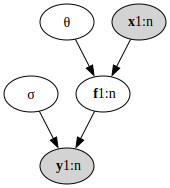

In [6]:
g3 = Digraph('gp')
g3.node('sigma', label='<&sigma;>')
g3.node('theta', label='<&theta;>')
g3.node('x1n', label='<<b>x</b><sub>1:n</sub>>', style='filled')
g3.node('f', label='<<b>f</b><sub>1:n</sub>>')
g3.node('y1n', label='<<b>y</b><sub>1:n</sub>>', style='filled')
g3.edge('theta', 'f')
g3.edge('x1n', 'f')
g3.edge('f', 'y1n')
g3.edge('sigma', 'y1n')
g3.render('gp_reg3', format='png')
g3

The graph shows how the joint distribution of all the variables decomposes in conditional probabilities.
You know that the parent nodes condition the children nodes.
Here is the decomposition here:

$$
p(\mathbf{x}_{1:n}, \mathbf{y}_{1:n}, \mathbf{f}_{1:n}, \theta, \sigma) =
p(\mathbf{y}_{1:n} | \mathbf{f}_{1:n}, \sigma) p(\mathbf{f}_{1:n} | \mathbf{x}_{1:n}, \theta)p(\theta)p(\sigma)p(\mathbf{x}_{1:n}).
$$

Now, by Bayes' rule, we know that the conditional joint probability density of all unobserved variables is proportional to the joint:

$$
p(\theta, \sigma, \mathbf{f}_{1:n} | \mathbf{x}_{1:n}, \mathbf{y}_{1:n}) \propto p(\mathbf{x}_{1:n}, \mathbf{y}_{1:n}, \mathbf{f}_{1:n}, \theta, \sigma).
$$

The normalization constant does not matter, i.e., we can drop $p(\mathbf{x}_{1:n})$, so we get:

$$
p(\theta, \sigma, \mathbf{f}_{1:n} | \mathbf{x}_{1:n}, \mathbf{y}_{1:n}) \propto p(\mathbf{y}_{1:n} | \mathbf{f}_{1:n}, \sigma) p(\mathbf{f}_{1:n} | \mathbf{x}_{1:n}, \theta)p(\theta)p(\sigma).
$$

Finally, to get the posterior over $\theta$ and $\sigma$ only, we *marginalize* (i.e., integrate out) the unobserved variable $\mathbf{f}_{1:n}$.
Here, the integral is analytically available (integral of Gaussian times a Gaussian, which is a Gaussian).
If you do the math, you will get:

$$
p(\theta,\sigma | \mathcal{D}) \propto \mathcal{N}\left(\mathbf{y}_{1:n}\middle|
\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) + \sigma^2\mathbf{I}_n\right) p(\theta)p(\sigma).
$$

### Maximum a Posteriori Estimate of the Hyperparameters

In the maximum a posteriori estimate (MAP), we approximate the posterior with the $\ delta$ function centered at its pick.
That is, we are approximating:

$$
p(\theta,\sigma|\mathcal{D}) \approx \delta(\theta-\theta^*)\delta(\sigma-\sigma^*),
$$

where $\theta^*$ and $\sigma^*$ are maximizing $\log p(\theta,\sigma|\mathcal{D})$.
It is instructive to see what $\log p(\theta,\sigma|\mathcal{D})$ looks like and see if we can assign any intuitive meaning to its terms.
It is:

$$
\begin{aligned}
\log p(\theta,\sigma|\mathcal{D}) =& \log \mathcal{N}\left(\mathbf{y}_{1:n}\middle|
\mathbf{m}(\mathbf{x}_{1:n}), \mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) + \sigma^2\mathbf{I}_n\right) + \log p(\theta) + \log p(\sigma) \\
=& 
-\frac{1}{2}\left(\mathbf{y}_{1:n}-\mathbf{m}(\mathbf{x}_{1:n})\right)^T\left(\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) + \sigma^2\mathbf{I}_n\right)^{-1}\left(\mathbf{y}_{1:n}-\mathbf{m}(\mathbf{x}_{1:n})\right)\\
&-\frac{1}{2}\log |\mathbf{K}(\mathbf{x}_{1:n},\mathbf{x}_{1:n}) + \sigma^2\mathbf{I}_n|\\
&+\log p(\theta) + \log p(\sigma)\\
& + \text{constants}.
\end{aligned}
$$

The constants are terms that do not depend on $\theta$ or $\sigma$.
The first term is a familiar one.
It looks like least squares (it is a form of least squares).
The third and fourth terms are familiar regularizers stemming from our prior knowledge.
The second term is a naturally occurring regularizer.

Now, back to solving the optimization problem that yields the MAP.
Of course, you need to get the derivatives of $\log p(\theta,\sigma|\mathcal{D})$ and use an optimization algorithm.
Back in the stone age, we were doing this by hand.
Now you don't have to worry about it.
Automatic differentiation can work through the entire expression (including the matrix determinant).
Once you have the derivative, you can use a gradient-based optimization algorithm from [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/optimize.html).
``GPy`` is using by default the [L-BFGS algorithm](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html) but you could change it if you want.
These are minimization algorithms.
So, ``GPy`` is actually minimizing $-\log p(\theta,\sigma)$.
Let's see how it works through our previous example: